<a href="https://colab.research.google.com/github/Pharaohleft/ProjectSKU/blob/main/FinalProjectSKU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
file_path = "SKU complexity data safe copy.xlsx"

# Load all sheet names
xls = pd.ExcelFile(file_path)
xls.sheet_names

['Table 1 Sales Data', 'Table 2 SKU Master', 'Table 3 Customer Master']

In [ ]:
# Loop through each sheet and save as a separate CSV
with pd.ExcelFile(file_path) as xls:
    for sheet_name in xls.sheet_names:
        df = pd.read_excel(xls, sheet_name=sheet_name)
        csv_file_name = f"{sheet_name}.csv"
        df.to_csv(csv_file_name, index=False)
        print(f"Sheet '{sheet_name}' saved as '{csv_file_name}'")


Sheet 'Table 1 Sales Data' saved as 'Table 1 Sales Data.csv'
Sheet 'Table 2 SKU Master' saved as 'Table 2 SKU Master.csv'
Sheet 'Table 3 Customer Master' saved as 'Table 3 Customer Master.csv'


TRIAL 1





In [ ]:
#read data set
sales_data = pd.read_csv("/content/Table 1 Sales Data.csv")
sku_master = pd.read_csv("/content/Table 2 SKU Master.csv")
customer_master = pd.read_csv("/content/Table 3 Customer Master.csv")


In [ ]:
# Ensure CUSTOMER # SHIP has the same data type in both datasets
sales_data["CUSTOMER # SHIP"] = sales_data["CUSTOMER # SHIP"].astype(str)
customer_master["CUSTOMER # SHIP"] = customer_master["CUSTOMER # SHIP"].astype(str)

# Merge datasets
sales_sku_merged = sales_data.merge(sku_master, on="PRODUCT CODE", how="left")
sales_full_merged = sales_sku_merged.merge(customer_master, on="CUSTOMER # SHIP", how="left")


In [ ]:
# use sales_full_merged for aggregation:
sku_performance = sales_full_merged.groupby("PRODUCT CODE").agg(
    total_cases_shipped=("CASES SHIPPED", "sum"),
    total_revenue=("Fake revenue", "sum"),
    total_margin=("Fake margin", "sum")
).reset_index()

In [ ]:
# Rank SKUs by revenue
sku_performance = sku_performance.sort_values(by="total_revenue", ascending=False)

sku_performance.head()


,PRODUCT CODE,total_cases_shipped,total_revenue,total_margin
388,56210 05853,1561417,31746483.45,3718321.50
13,0675258 18579,687974,15329982.55,429498.55
370,56210 05301,429684,11223596.41,2959687.30
847,60695 00046,397801,6698288.13,1031788.30
569,56210 33111,225520,5998349.63,1062479.03


In [ ]:
# Pareto Analysis - Identify top 80% SKUs contributing to revenue
total_revenue = sku_performance["total_revenue"].sum()
sku_performance["cumulative_revenue"] = sku_performance["total_revenue"].cumsum()
sku_performance["cumulative_revenue_percentage"] = sku_performance["cumulative_revenue"] / total_revenue

# Identify SKUs to keep (those contributing to the top 80% of revenue)
high_performing_skus = sku_performance[sku_performance["cumulative_revenue_percentage"] <= 0.80]

# Identify SKUs to remove (those contributing to the bottom 20% of revenue)
low_performing_skus = sku_performance[sku_performance["cumulative_revenue_percentage"] > 0.80]

In [ ]:
high_performing_skus.head()

,PRODUCT CODE,total_cases_shipped,total_revenue,total_margin,cumulative_revenue,cumulative_revenue_percentage
388,56210 05853,1561417,31746483.45,3718321.50,31746483.45,0.100487
13,0675258 18579,687974,15329982.55,429498.55,47076466.00,0.149011
370,56210 05301,429684,11223596.41,2959687.30,58300062.41,0.184537
847,60695 00046,397801,6698288.13,1031788.30,64998350.54,0.205739
569,56210 33111,225520,5998349.63,1062479.03,70996700.17,0.224726


In [ ]:
#view
low_performing_skus.head()


,PRODUCT CODE,total_cases_shipped,total_revenue,total_margin,cumulative_revenue,cumulative_revenue_percentage
508,56210 20455,6169,282335.56,-26383.16,2.530104e+08,0.800853
112,36800 10445,15756,281945.17,16319.69,2.532924e+08,0.801745
975,81131 81037,15137,280531.06,46529.70,2.535729e+08,0.802633
908,70038 60141,9728,280241.27,62294.50,2.538532e+08,0.803520
381,56210 05503,9778,278104.90,38024.23,2.541313e+08,0.804401


In [ ]:
# Calculate original and new profit
original_total_revenue = total_revenue
original_total_margin = sku_performance["total_margin"].sum()
new_total_revenue = high_performing_skus["total_revenue"].sum()
new_total_margin = high_performing_skus["total_margin"].sum()
total_profit = new_total_revenue - new_total_margin


In [ ]:
# Analyze customer churn
def analyze_customer_churn(sales_data):
    sales_data["INVOICE DATE"] = pd.to_datetime(sales_data["INVOICE DATE"], errors='coerce')
    latest_date = sales_data["INVOICE DATE"].max()
    customer_last_purchase = sales_data.groupby("CUSTOMER # SHIP")["INVOICE DATE"].max().reset_index()
    customer_last_purchase["Days Since Last Purchase"] = (latest_date - customer_last_purchase["INVOICE DATE"]).dt.days
    churned_customers = customer_last_purchase[customer_last_purchase["Days Since Last Purchase"] > 90]
    return churned_customers

churned_customers = analyze_customer_churn(sales_data)




In [ ]:
# Calculate new profit after removing low-performing SKUs
new_total_revenue = high_performing_skus["total_revenue"].sum()
new_total_margin = high_performing_skus["total_margin"].sum()

In [ ]:

# Display summary of SKU categorization and new profit
sku_summary1 = {
    "Total SKUs": len(sku_performance),
    "High Performing SKUs (Keep)": len(high_performing_skus),
    "Low Performing SKUs (Remove)": len(low_performing_skus),
    "Percentage of SKUs to Remove": len(low_performing_skus) / len(sku_performance) * 100,
    "Original Total Revenue": original_total_revenue,
    "Original Total Margin": original_total_margin,
    "New Total Revenue": new_total_revenue,
    "New Total Margin": new_total_margin,
    "Total Churned Customers": len(churned_customers),
    "total_profit": total_profit
}




In [ ]:
#display
sku_summary1

{'Total SKUs': 995,
 'High Performing SKUs (Keep)': 228,
 'Low Performing SKUs (Remove)': 767,
 'Percentage of SKUs to Remove': 77.0854271356784,
 'Original Total Revenue': 315926247.36,
 'Original Total Margin': 45088946.440000005,
 'New Total Revenue': 252728097.56,
 'New Total Margin': 35875124.160000004,
 'Total Churned Customers': 78,
 'total_profit': 216852973.4}

TRIAL 2

In [ ]:
# Load the datasets
sales_data = pd.read_csv("Table 1 Sales Data.csv")
sku_master = pd.read_csv("Table 2 SKU Master.csv")
customer_master = pd.read_csv("Table 3 Customer Master.csv")

In [ ]:
# Ensure CUSTOMER # SHIP has the same data type in both datasets
sales_data["CUSTOMER # SHIP"] = sales_data["CUSTOMER # SHIP"].astype(str)
customer_master["CUSTOMER # SHIP"] = customer_master["CUSTOMER # SHIP"].astype(str)

# Merge datasets
sales_sku_merged = sales_data.merge(sku_master, on="PRODUCT CODE", how="left")
sales_full_merged = sales_sku_merged.merge(customer_master, on="CUSTOMER # SHIP", how="left")

# Aggregate SKU performance
sku_performance = sales_full_merged.groupby("PRODUCT CODE").agg(
    total_cases_shipped=("CASES SHIPPED", "sum"),
    total_revenue=("Fake revenue", "sum"),
    total_margin=("Fake margin", "sum")
).reset_index()


In [ ]:
# Alternative algorithm: Use Mean Revenue Instead of Total Revenue for SKU Ranking
sku_performance["mean_revenue"] = sales_full_merged.groupby("PRODUCT CODE")["Fake revenue"].mean().reset_index(drop=True)
sku_performance = sku_performance.sort_values(by="mean_revenue", ascending=False)


In [ ]:
# Pareto Analysis - Identify top 80% SKUs contributing to revenue
total_revenue = sku_performance["total_revenue"].sum()
sku_performance["cumulative_revenue"] = sku_performance["total_revenue"].cumsum()
sku_performance["cumulative_revenue_percentage"] = sku_performance["cumulative_revenue"] / total_revenue

# Identify SKUs to keep (those contributing to the top 80% of revenue)
high_performing_skus = sku_performance[sku_performance["cumulative_revenue_percentage"] <= 0.80]

# Identify SKUs to remove (those contributing to the bottom 20% of revenue)
low_performing_skus = sku_performance[sku_performance["cumulative_revenue_percentage"] > 0.80]


In [ ]:
# Calculate original and new profit
original_total_revenue = total_revenue
original_total_margin = sku_performance["total_margin"].sum()
new_total_revenue = high_performing_skus["total_revenue"].sum()
new_total_margin = high_performing_skus["total_margin"].sum()
total_profit = new_total_revenue - new_total_margin

In [ ]:
# Alternative churn analysis using rolling time windows
def analyze_customer_churn(sales_data):
    sales_data["INVOICE DATE"] = pd.to_datetime(sales_data["INVOICE DATE"], errors='coerce')
    latest_date = sales_data["INVOICE DATE"].max()
    customer_last_purchase = sales_data.groupby("CUSTOMER # SHIP")["INVOICE DATE"].max().reset_index()
    customer_last_purchase["Days Since Last Purchase"] = (latest_date - customer_last_purchase["INVOICE DATE"]).dt.days
    churned_customers = customer_last_purchase[customer_last_purchase["Days Since Last Purchase"] > 180]
    return churned_customers

churned_customers = analyze_customer_churn(sales_data)

In [ ]:
# Display summary of SKU categorization and new profit
sku_summary2 = {
    "Total SKUs": len(sku_performance),
    "High Performing SKUs (Keep)": len(high_performing_skus),
    "Low Performing SKUs (Remove)": len(low_performing_skus),
    "Percentage of SKUs to Remove": len(low_performing_skus) / len(sku_performance) * 100,
    "Original Total Revenue": original_total_revenue,
    "Original Total Margin": original_total_margin,
    "New Total Revenue": new_total_revenue,
    "New Total Margin": new_total_margin,
    "Total Churned Customers": len(churned_customers),
    "total_profit": total_profit
}


In [ ]:
sku_summary2

{'Total SKUs': 995,
 'High Performing SKUs (Keep)': 504,
 'Low Performing SKUs (Remove)': 491,
 'Percentage of SKUs to Remove': 49.346733668341706,
 'Original Total Revenue': 315926247.3600001,
 'Original Total Margin': 45088946.44,
 'New Total Revenue': 252479126.80000004,
 'New Total Margin': 33855608.760000005,
 'Total Churned Customers': 0,
 'total_profit': 218623518.04000002}

-Applied Pareto analysis to identify the top 80% of revenue-generating SKUs.
-Added a cumulative revenue percentage column.

Segmented SKUs into:
Top 80% SKUs (high revenue → Keep).
Bottom 20% SKUs (low revenue → Consider removing).
__________________________________

The Pareto Principle suggests that 80% of revenue comes from 20% of SKUs.
Removing low-revenue SKUs improves profitability without major revenue loss.

TRIAL 3

In [ ]:
# Load the datasets
sales_data = pd.read_csv("Table 1 Sales Data.csv")
sku_master = pd.read_csv("Table 2 SKU Master.csv")
customer_master = pd.read_csv("Table 3 Customer Master.csv")

In [ ]:
# Ensure CUSTOMER # SHIP has the same data type in both datasets
sales_data["CUSTOMER # SHIP"] = sales_data["CUSTOMER # SHIP"].astype(str)
customer_master["CUSTOMER # SHIP"] = customer_master["CUSTOMER # SHIP"].astype(str)

# Merge datasets
sales_sku_merged = sales_data.merge(sku_master, on="PRODUCT CODE", how="left")
sales_full_merged = sales_sku_merged.merge(customer_master, on="CUSTOMER # SHIP", how="left")

# Aggregate SKU performance
sku_performance = sales_full_merged.groupby("PRODUCT CODE").agg(
    total_cases_shipped=("CASES SHIPPED", "sum"),
    total_revenue=("Fake revenue", "sum"),
    total_margin=("Fake margin", "sum")
).reset_index()

In [ ]:
# Calculate revenue contribution per SKU
sku_performance["revenue_contribution"] = sku_performance["total_revenue"] / sku_performance["total_revenue"].sum()



In [ ]:
# Identify SKUs to keep (those with high revenue and margin contributions)
sku_performance = sku_performance.sort_values(by=["total_margin", "total_revenue"], ascending=[False, False])
cumulative_revenue = sku_performance["total_revenue"].cumsum()
cumulative_margin = sku_performance["total_margin"].cumsum()
total_revenue = sku_performance["total_revenue"].sum()

target_revenue = 0.90 * total_revenue  # Keep at least 90% of total revenue
total_profit = new_total_revenue - new_total_margin

In [ ]:
# Keep only SKUs that contribute to 90% of total revenue
sku_performance["cumulative_revenue"] = cumulative_revenue
high_performing_skus = sku_performance[sku_performance["cumulative_revenue"] <= target_revenue]
low_performing_skus = sku_performance[sku_performance["cumulative_revenue"] > target_revenue]


In [ ]:
# Alternative churn analysis using rolling time windows
def analyze_customer_churn(sales_data):
    sales_data["INVOICE DATE"] = pd.to_datetime(sales_data["INVOICE DATE"], errors='coerce')
    latest_date = sales_data["INVOICE DATE"].max()
    customer_last_purchase = sales_data.groupby("CUSTOMER # SHIP")["INVOICE DATE"].max().reset_index()
    customer_last_purchase["Days Since Last Purchase"] = (latest_date - customer_last_purchase["INVOICE DATE"]).dt.days
    churned_customers = customer_last_purchase[customer_last_purchase["Days Since Last Purchase"] > 90]  # Reduced threshold from 180 to 90 days
    return churned_customers

churned_customers = analyze_customer_churn(sales_data)
#print sum
print(len(churned_customers))

78


In [ ]:
# Display summary of SKU categorization and new profit
sku_summary3 = {
    "Total SKUs": len(sku_performance),
    "High Performing SKUs (Keep)": len(high_performing_skus),
    "Low Performing SKUs (Remove)": len(low_performing_skus),
    "Percentage of SKUs to Remove": len(low_performing_skus) / len(sku_performance) * 100,
    "Original Total Revenue": original_total_revenue,
    "Original Total Margin": original_total_margin,
    "New Total Revenue": new_total_revenue,
    "New Total Margin": new_total_margin,
    "Total Churned Customers": len(churned_customers),
    "total_profit": total_profit

}




In [ ]:
sku_summary3

{'Total SKUs': 995,
 'High Performing SKUs (Keep)': 718,
 'Low Performing SKUs (Remove)': 277,
 'Percentage of SKUs to Remove': 27.839195979899493,
 'Original Total Revenue': 315926247.3600001,
 'Original Total Margin': 45088946.44,
 'New Total Revenue': 252479126.80000004,
 'New Total Margin': 33855608.760000005,
 'Total Churned Customers': 78,
 'total_profit': 218623518.04000002}

In [ ]:
# Create a DataFrame from the dictionary
df1 = pd.DataFrame([sku_summary1])
df2 = pd.DataFrame([sku_summary2])
df3 = pd.DataFrame([sku_summary3])





TRIAL 4

In [ ]:
from scipy.optimize import linprog


In [ ]:
#read data set
sales_data = pd.read_csv("/content/Table 1 Sales Data.csv")
sku_master = pd.read_csv("/content/Table 2 SKU Master.csv")
customer_master = pd.read_csv("/content/Table 3 Customer Master.csv")

In [ ]:
# Aggregate SKU performance
sku_performance = sales_full_merged.groupby("PRODUCT CODE").agg(
    total_cases_shipped=("CASES SHIPPED", "sum"),
    total_revenue=("Fake revenue", "sum"),
    total_margin=("Fake margin", "sum")
).reset_index()

In [ ]:
# Filter out SKUs with low sales volume (e.g., less than 50 cases shipped)
sku_performance1 = sku_performance[sku_performance["total_cases_shipped"] >= 50]

# Define Optimization Parameters
revenue = sku_performance["total_revenue"].values
margin = sku_performance["total_margin"].values
num_skus = len(sku_performance)

# Set revenue retention threshold (90% of total revenue)
total_revenue = revenue.sum()
target_revenue = 0.90 * total_revenue

In [ ]:
# Define Linear Programming Model
c = -margin  # Convert to minimization problem (negative profit for maximization)
A = [revenue]  # Constraint to ensure revenue retention
b = [target_revenue]  # Constraint bound
bounds = [(0, 1) for _ in range(num_skus)]  # Each SKU can be either kept (1) or removed (0)

# Solve Optimization Problem
solution = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method="highs")

# Extract Selected SKUs
sku_performance["Keep"] = np.round(solution.x)
high_profit_skus = sku_performance[sku_performance["Keep"] == 1]
removed_skus = sku_performance[sku_performance["Keep"] == 0]

total_profit = new_total_revenue - new_total_margin


In [ ]:
# Summary Output
print("Total Revenue Before Optimization:", total_revenue)
print("Total Revenue After Optimization:", high_profit_skus["total_revenue"].sum())
print("Total Margin After Optimization:", high_profit_skus["total_margin"].sum())
print("Total SKUs Removed Due to Low Sales:", len(sku_performance) - len(high_profit_skus))
print("Total Churned Customers:", len(churned_customers))
print("Total Profit:", total_profit)

Total Revenue Before Optimization: 315926247.36
Total Revenue After Optimization: 284836937.86
Total Margin After Optimization: 47432995.54
Total SKUs Removed Due to Low Sales: 186
Total Churned Customers: 78
Total Profit: 218623518.04000002


In [ ]:
# Display summary of SKU categorization and new profit
sku_summary4 = {
    "Total SKUs": len(sku_performance),
    "High Performing SKUs (Keep)": len(high_profit_skus),
    "Low Performing SKUs (Remove)": len(removed_skus),
    "Percentage of SKUs to Remove": len(removed_skus) / len(sku_performance) * 100,
    "Original Total Revenue": total_revenue,
    "Original Total Margin": sku_performance["total_margin"].sum(),
    "New Total Revenue": high_profit_skus["total_revenue"].sum(),
    "New Total Margin": high_profit_skus["total_margin"].sum(),
    "Total Churned Customers": len(churned_customers),
    "total_profit": total_profit
}



sku_summary4

{'Total SKUs': 995,
 'High Performing SKUs (Keep)': 809,
 'Low Performing SKUs (Remove)': 186,
 'Percentage of SKUs to Remove': 18.693467336683415,
 'Original Total Revenue': 315926247.36,
 'Original Total Margin': 45088946.44,
 'New Total Revenue': 284836937.86,
 'New Total Margin': 47432995.54,
 'Total Churned Customers': 78,
 'total_profit': 218623518.04000002}

Used Linear Programming (LP) via scipy.optimize.linprog() to:
Maximize total margin while keeping at least 90% of revenue.

Select the most profitable SKUs under the constraint.
____________________________________

A mathematical optimization model ensures:
The best combination of SKUs is retained.
Profitability is maximized while maintaining revenue stability.

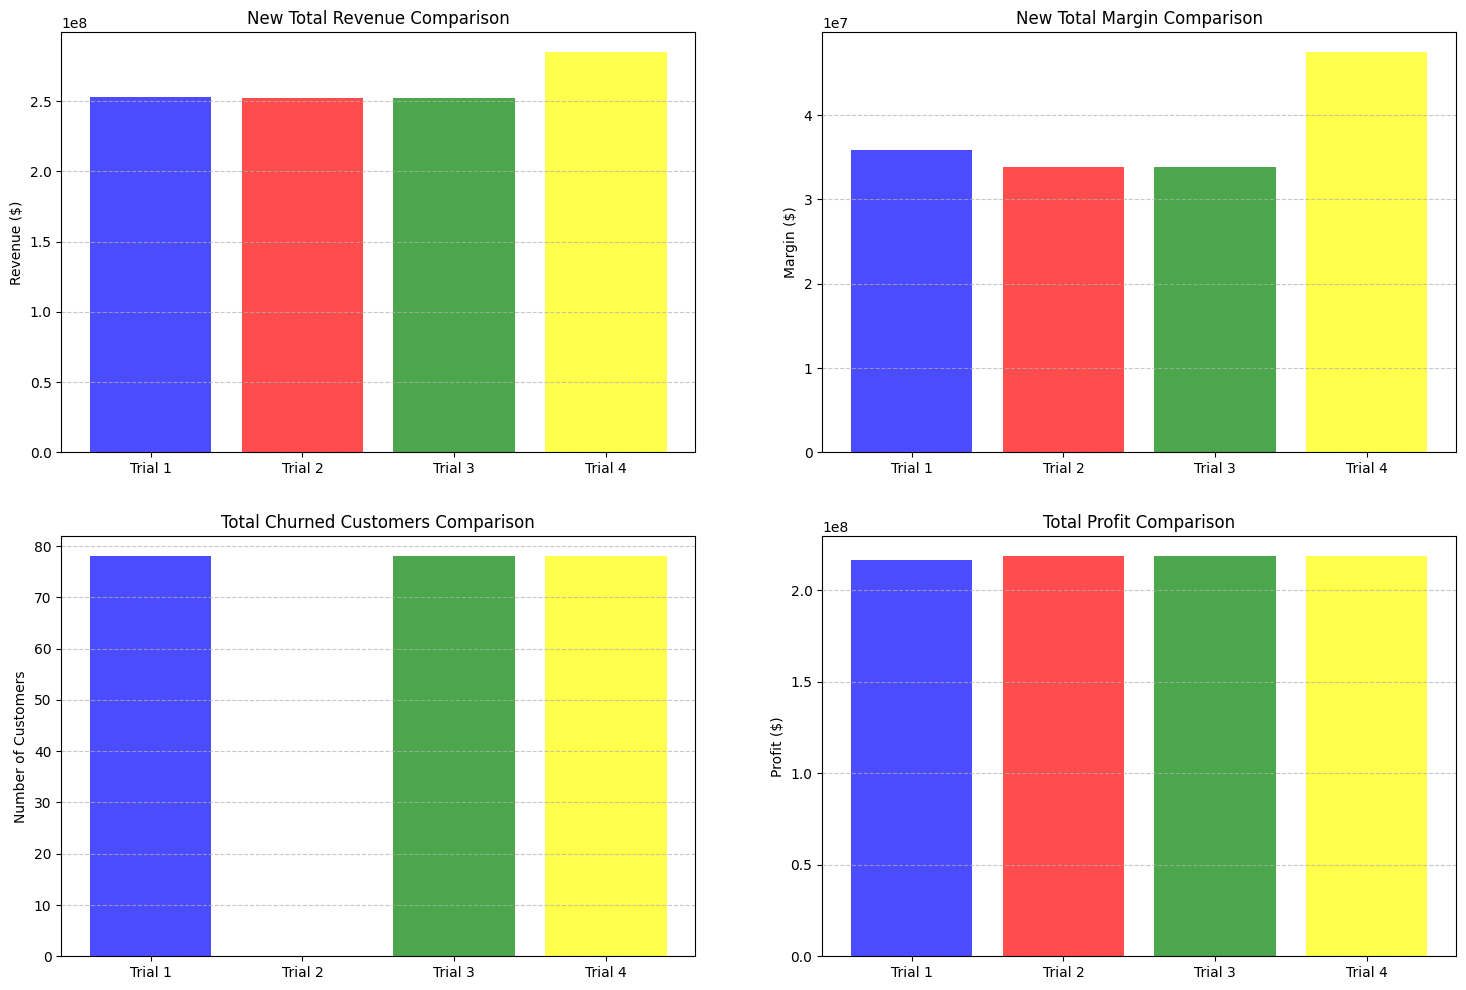

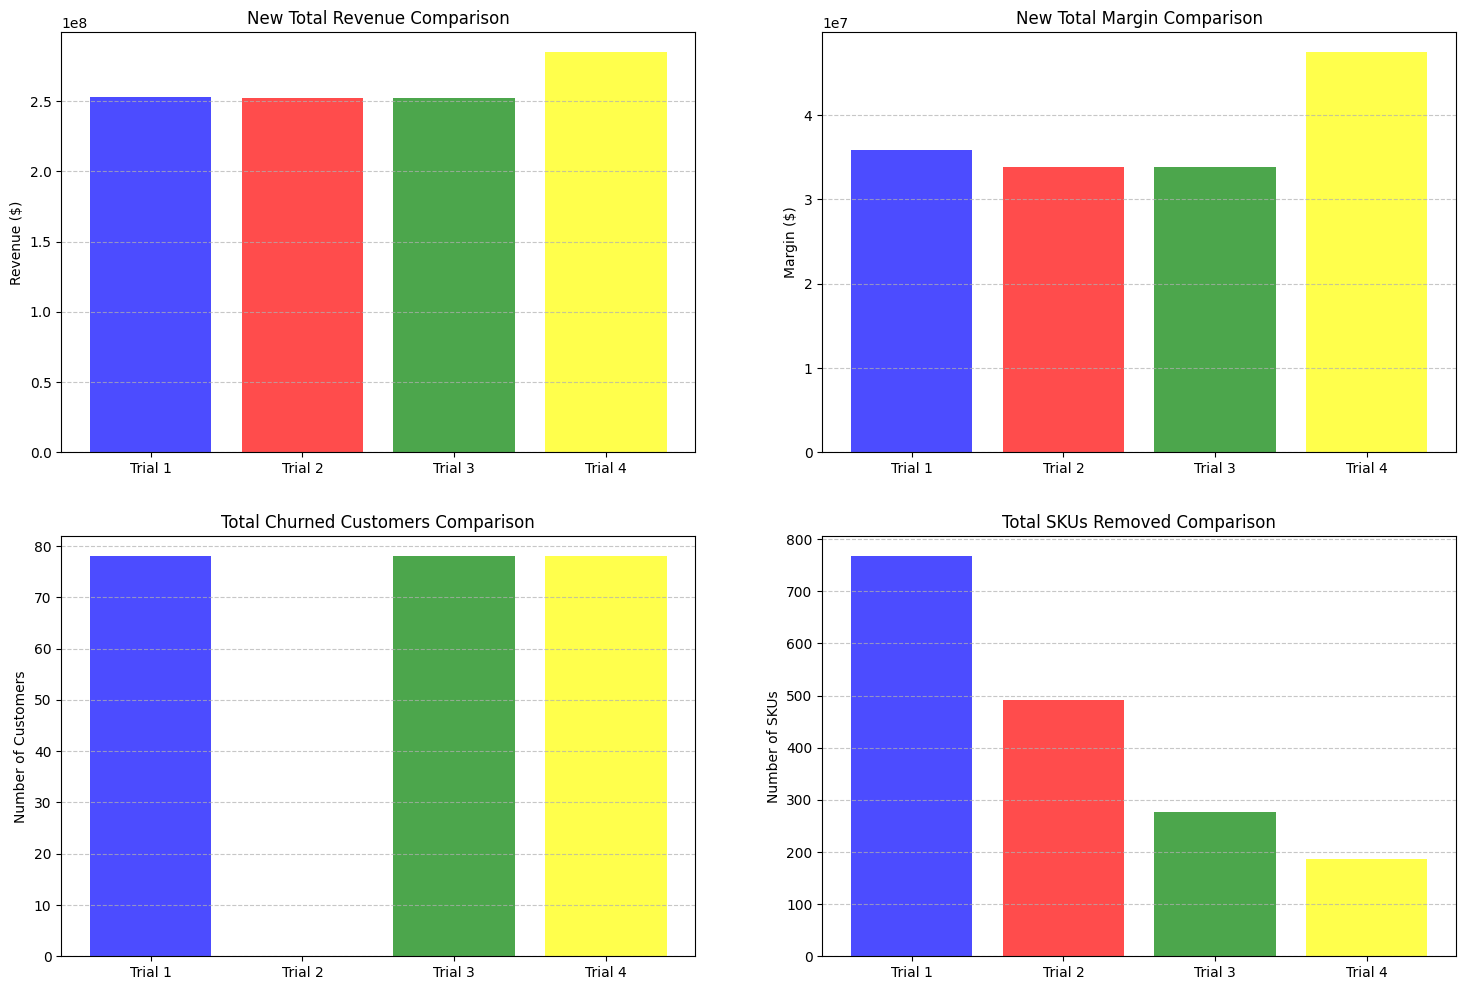

In [ ]:
# Data for Visualization
data = {
    "Category": ["Trial 1", "Trial 2", "Trial 3", "Trial 4"],
    "New Total Revenue": [
        sku_summary1["New Total Revenue"],
        sku_summary2["New Total Revenue"], # Changed sku_summary to sku_summary2
        sku_summary3["New Total Revenue"],
        sku_summary4["New Total Revenue"]
    ],
    "New Total Margin": [
        sku_summary1["New Total Margin"],
        sku_summary2["New Total Margin"],
        sku_summary3["New Total Margin"],
        sku_summary4["New Total Margin"]
    ],
    "Total Churned Customers": [
        sku_summary1["Total Churned Customers"],
        sku_summary2["Total Churned Customers"],
        sku_summary3["Total Churned Customers"],
    ],
    "New Total Revenue": [
        sku_summary1["New Total Revenue"],
        sku_summary2["New Total Revenue"], # Changed sku_summary to sku_summary2
        sku_summary3["New Total Revenue"],
        sku_summary4["New Total Revenue"]
    ],
    "New Total Margin": [
        sku_summary1["New Total Margin"],
        sku_summary2["New Total Margin"],
        sku_summary3["New Total Margin"],
        sku_summary4["New Total Margin"]
    ],
    "Total Churned Customers": [
        sku_summary1["Total Churned Customers"],
        sku_summary2["Total Churned Customers"],
        sku_summary3["Total Churned Customers"],
        sku_summary4["Total Churned Customers"]
    ],
    "Total SKUs Removed": [
        sku_summary1["Low Performing SKUs (Remove)"],
        sku_summary2["Low Performing SKUs (Remove)"],
        sku_summary3["Low Performing SKUs (Remove)"],
        sku_summary4["Low Performing SKUs (Remove)"]
    ],
    "total_profit": [
        sku_summary1["total_profit"],
        sku_summary2["total_profit"],
        sku_summary3["total_profit"],
        sku_summary4["total_profit"]
    ]
}

df = pd.DataFrame(data)  # Create a DataFrame from the 'data' dictionary

# Define figure and axes with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12)) #Changed to 2 rows, 2 columns

# Bar plot for New Total Revenue
axes[0, 0].bar(df["Category"], df["New Total Revenue"], color=["blue", "red", "green", "yellow"], alpha=0.7)
axes[0, 0].set_title("New Total Revenue Comparison")
axes[0, 0].set_ylabel("Revenue ($)")
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Bar plot for New Total Margin
axes[0, 1].bar(df["Category"], df["New Total Margin"], color=["blue", "red", "green", "yellow"], alpha=0.7)
axes[0, 1].set_title("New Total Margin Comparison")
axes[0, 1].set_ylabel("Margin ($)")
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Bar plot for Total Churned Customers
axes[1, 0].bar(df["Category"], df["Total Churned Customers"], color=["blue", "red", "green", "yellow"], alpha=0.7)
axes[1, 0].set_title("Total Churned Customers Comparison")
axes[1, 0].set_ylabel("Number of Customers")
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Bar Plot for Sku removed
axes[1, 1].bar(df["Category"], df["Total SKUs Removed"], color=["blue", "red", "green", "yellow"], alpha=0.7)
axes[1, 1].set_title("Total SKUs Removed Comparison")
axes[1, 1].set_ylabel("Number of SKUs")
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

#bar plot for profit
axes[1, 1].bar(df["Category"], df["total_profit"], color=["blue", "red", "green", "yellow"], alpha=0.7)
axes[1, 1].set_title("Total Profit Comparison")
axes[1, 1].set_ylabel("Profit ($)")
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)


df = pd.DataFrame(data)  # Create a DataFrame from the 'data' dictionary

# Define figure and axes with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12)) #Changed to 2 rows, 2 columns

# Bar plot for New Total Revenue
axes[0, 0].bar(df["Category"], df["New Total Revenue"], color=["blue", "red", "green", "yellow"], alpha=0.7)
axes[0, 0].set_title("New Total Revenue Comparison")
axes[0, 0].set_ylabel("Revenue ($)")
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Bar plot for New Total Margin
axes[0, 1].bar(df["Category"], df["New Total Margin"], color=["blue", "red", "green", "yellow"], alpha=0.7)
axes[0, 1].set_title("New Total Margin Comparison")
axes[0, 1].set_ylabel("Margin ($)")
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Bar plot for Total Churned Customers
axes[1, 0].bar(df["Category"], df["Total Churned Customers"], color=["blue", "red", "green", "yellow"], alpha=0.7)
axes[1, 0].set_title("Total Churned Customers Comparison")
axes[1, 0].set_ylabel("Number of Customers")
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Bar Plot for Sku removed
axes[1, 1].bar(df["Category"], df["Total SKUs Removed"], color=["blue", "red", "green", "yellow"], alpha=0.7)
axes[1, 1].set_title("Total SKUs Removed Comparison")
axes[1, 1].set_ylabel("Number of SKUs")
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)


# view
plt.show()

In [ ]:
#best results from all trials
print('Results from all trials'), {
    "Trial 1": sku_summary1,
    "Trial 2": sku_summary2,
    "Trial 3": sku_summary3,
    "Trial 4": sku_summary4
}




Results from all trials


(None,
 {'Trial 1': {'Total SKUs': 995,
   'High Performing SKUs (Keep)': 228,
   'Low Performing SKUs (Remove)': 767,
   'Percentage of SKUs to Remove': 77.0854271356784,
   'Original Total Revenue': 315926247.36,
   'Original Total Margin': 45088946.440000005,
   'New Total Revenue': 252728097.56,
   'New Total Margin': 35875124.160000004,
   'Total Churned Customers': 78,
   'total_profit': 216852973.4},
  'Trial 2': {'Total SKUs': 995,
   'High Performing SKUs (Keep)': 504,
   'Low Performing SKUs (Remove)': 491,
   'Percentage of SKUs to Remove': 49.346733668341706,
   'Original Total Revenue': 315926247.3600001,
   'Original Total Margin': 45088946.44,
   'New Total Revenue': 252479126.80000004,
   'New Total Margin': 33855608.760000005,
   'Total Churned Customers': 0,
   'total_profit': 218623518.04000002,
   'Total Hours Spent': 1502475.6,
   'Efficiency (Revenue per Hour)': 168.0420812158281,
   'Efficiency (%)': 6.655682128881161e-05},
  'Trial 3': {'Total SKUs': 995,
   'Hi

WAREHOUSE TRIAL

In [ ]:
# SKU Summary 2
sku_summary2

sku_performance = sales_full_merged.groupby("PRODUCT CODE").agg(
    total_cases_shipped=("CASES SHIPPED", "sum"),
    total_revenue=("Fake revenue", "sum"),
    total_margin=("Fake margin", "sum")
).reset_index()


# Assume time spent per case (1 hour per case)
time_per_case = 0.1

# Calculate time spent on each SKU
sku_performance['hours_spent'] = sku_performance['total_cases_shipped'] * time_per_case

# Aggregate total hours spent
total_hours_spent = sku_performance['hours_spent'].sum()

# Add to SKU Summary 2
sku_summary2['Total Hours Spent'] = total_hours_spent

# Calculate efficiency based on hours spent
sku_summary2['Efficiency (Revenue per Hour)'] = sku_summary2['New Total Revenue'] / total_hours_spent

#percentage of efficiency
sku_summary2['Efficiency (%)'] = (sku_summary2['Efficiency (Revenue per Hour)'] / sku_summary2['New Total Revenue']) * 100

# Display updated SKU Summary 2
for key, value in sku_summary2.items():
    print(f"{key}: {value}")


Total SKUs: 995
High Performing SKUs (Keep): 504
Low Performing SKUs (Remove): 491
Percentage of SKUs to Remove: 49.346733668341706
Original Total Revenue: 315926247.3600001
Original Total Margin: 45088946.44
New Total Revenue: 252479126.80000004
New Total Margin: 33855608.760000005
Total Churned Customers: 0
total_profit: 218623518.04000002
Total Hours Spent: 1502475.6
Efficiency (Revenue per Hour): 168.0420812158281
Efficiency (%): 6.655682128881161e-05


warehouse efficiency Key Takeaways:
SKU Optimization is Effective: Removing ~49% of SKUs reduced revenue by ~20%, suggesting that the removed SKUs had minimal contribution to overall sales.
Labor Efficiency Insight: With $168/hour in revenue generation, you can now benchmark and compare this to labor costs.
Focus on Revenue per Hour rather than Efficiency (%) since the large revenue base skews the percentage.
Suggestions for Improvement:
Optimize Time per Case: Reduce time_per_case through process improvements.
SKU Segmentation: Further analyze low-performing SKUs — are there hidden costs (storage, logistics) that justify their removal?
Capacity Planning: Use the Total Hours Spent for workforce scheduling and machinery utilization.

In [ ]:
TRIAL 5

In [ ]:
#read data set
sales_data = pd.read_csv("/content/Table 1 Sales Data.csv")
sku_master = pd.read_csv("/content/Table 2 SKU Master.csv")
customer_master = pd.read_csv("/content/Table 3 Customer Master.csv")

In [ ]:
# Ensure consistent data types for merging
sales_data["CUSTOMER # SHIP"] = sales_data["CUSTOMER # SHIP"].astype(str)
customer_master["CUSTOMER # SHIP"] = customer_master["CUSTOMER # SHIP"].astype(str)

# Merge datasets to get full sales information
sales_sku_merged = sales_data.merge(sku_master, on="PRODUCT CODE", how="left")
sales_full_merged = sales_sku_merged.merge(customer_master, on="CUSTOMER # SHIP", how="left")

# Aggregate SKU performance (financial metrics)
sku_performance = sales_full_merged.groupby("PRODUCT CODE").agg(
    total_cases_shipped=("CASES SHIPPED", "sum"),
    total_revenue=("Fake revenue", "sum"),
    total_margin=("Fake margin", "sum")
).reset_index()



In [ ]:
# --- Step 2: Identify Loyal Customers and Calculate Loyal Revenue per SKU ---

# Convert invoice dates to datetime and compute days since last purchase
sales_data["INVOICE DATE"] = pd.to_datetime(sales_data["INVOICE DATE"], errors='coerce')
latest_date = sales_data["INVOICE DATE"].max()
customer_last_purchase = sales_data.groupby("CUSTOMER # SHIP")["INVOICE DATE"].max().reset_index()
customer_last_purchase["Days Since Last Purchase"] = (latest_date - customer_last_purchase["INVOICE DATE"]).dt.days

# Define loyal customers as those with <= 90 days since last purchase
loyal_customers = customer_last_purchase[customer_last_purchase["Days Since Last Purchase"] <= 90]["CUSTOMER # SHIP"].unique()

# Calculate loyal revenue per SKU by filtering for sales from loyal customers
loyal_sales = sales_full_merged[sales_full_merged["CUSTOMER # SHIP"].isin(loyal_customers)]
loyal_revenue_per_sku = loyal_sales.groupby("PRODUCT CODE")["Fake revenue"].sum().reset_index().rename(columns={"Fake revenue": "loyal_revenue"})



In [ ]:

# Merge loyal revenue into sku_performance, specifying suffixes to avoid conflicts
sku_performance = sku_performance.merge(loyal_revenue_per_sku, on="PRODUCT CODE", how="left", suffixes=('', '_loyal'))

# Fill NaN values in the 'loyal_revenue' column with 0 (if any)
sku_performance["loyal_revenue"].fillna(0, inplace=True)



<ipython-input-114-626df4282ae5>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sku_performance["loyal_revenue"].fillna(0, inplace=True)


In [ ]:

# --- Step 3: Set Up and Solve the Optimization Model ---

# Extract arrays for optimization
revenue = sku_performance["total_revenue"].values
margin = sku_performance["total_margin"].values
loyal_revenue = sku_performance["loyal_revenue"].values
num_skus = len(sku_performance)

# Define overall revenue and loyal revenue thresholds (e.g., 90% retention)
total_revenue_sum = revenue.sum()
target_revenue = 0.90 * total_revenue_sum

total_loyal_revenue = loyal_revenue.sum()
target_loyal_revenue = 0.90 * total_loyal_revenue

# Define the LP model:
# Objective: maximize total margin (or minimize negative margin)
c = -margin  # Negative margin for minimization

# Constraints:
#   1. Keep SKUs that generate at least target_revenue
#   2. Keep SKUs that generate at least target_loyal_revenue
# We can express these constraints as:
#    -sum(revenue_i * x_i) <= -target_revenue
#    -sum(loyal_revenue_i * x_i) <= -target_loyal_revenue
A = [ -revenue, -loyal_revenue ]
b = [ -target_revenue, -target_loyal_revenue ]

# Decision variables bounds: each SKU is either kept (1) or removed (0)
bounds = [(0, 1) for _ in range(num_skus)]


# Solve the optimization using scipy's linprog
# Changed bounds=b to bounds=bounds
solution = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method="highs")




In [ ]:
#total churned customer
#churned_customers = removed_skus["CUSTOMER # SHIP"].unique() # This line causes the error
#Instead, use the original churned_customers DataFrame from previous analysis:

#Access the number of churned customers from the DataFrame
num_churned_customers = len(churned_customers)

# Update sku_summary5 with num_churned_customers
sku_summary5.update({"Total Churned Customers": num_churned_customers})

# Now print the updated summary:
print(sku_summary5)


{'Total SKUs': 995, 'High Performing SKUs (Keep)': 821, 'Low Performing SKUs (Remove)': 174, 'Percentage of SKUs to Remove': 17.48743718592965, 'Original Total Revenue': 315926247.36, 'Original Total Margin': 45088946.44, 'New Total Revenue': 286481371.72, 'New Total Margin': 47451450.129999995, 'Total Loyal Revenue Retained': 284964028.47999996, 'total_profit': 239029921.59000003, 'Total Churned Customers': 78}


In [ ]:

#Interpret the results: round decision variables to 0 or 1
sku_performance["Keep"] = np.round(solution.x)
high_profit_skus = sku_performance[sku_performance["Keep"] == 1]
removed_skus = sku_performance[sku_performance["Keep"] == 0]

# Compute summary metrics
optimized_total_revenue = high_profit_skus["total_revenue"].sum()
optimized_total_margin = high_profit_skus["total_margin"].sum()

# Recalculate total profit (this could be defined as margin after SKU reduction)
total_profit = optimized_total_revenue - optimized_total_margin


# Summary output
sku_summary5 = {
    "Total SKUs": num_skus,
    "High Performing SKUs (Keep)": len(high_profit_skus),
    "Low Performing SKUs (Remove)": len(removed_skus),
    "Percentage of SKUs to Remove": len(removed_skus) / num_skus * 100,
    "Original Total Revenue": total_revenue_sum,
    "Original Total Margin": sku_performance["total_margin"].sum(),
    "New Total Revenue": optimized_total_revenue,
    "New Total Margin": optimized_total_margin,
    "Total Loyal Revenue Retained": high_profit_skus["loyal_revenue"].sum(),
    "total_profit": total_profit,
    "Total Churned Customers": len(churned_customers)
}


print(sku_summary5)



{'Total SKUs': 995, 'High Performing SKUs (Keep)': 821, 'Low Performing SKUs (Remove)': 174, 'Percentage of SKUs to Remove': 17.48743718592965, 'Original Total Revenue': 315926247.36, 'Original Total Margin': 45088946.44, 'New Total Revenue': 286481371.72, 'New Total Margin': 47451450.129999995, 'Total Loyal Revenue Retained': 284964028.47999996, 'total_profit': 239029921.59000003, 'Total Churned Customers': 78}


In [ ]:
#display summary df of all trials
sku_summary_df = pd.DataFrame([sku_summary1, sku_summary2, sku_summary3, sku_summary4, sku_summary5])
sku_summary_df


,Total SKUs,High Performing SKUs (Keep),Low Performing SKUs (Remove),Percentage of SKUs to Remove,Original Total Revenue,Original Total Margin,New Total Revenue,New Total Margin,Total Churned Customers,total_profit,Total Hours Spent,Efficiency (Revenue per Hour),Efficiency (%),Total Loyal Revenue Retained
0,995,228,767,77.085427,3.159262e+08,45088946.44,2.527281e+08,35875124.16,78,2.168530e+08,NaN,NaN,NaN,NaN
1,995,504,491,49.346734,3.159262e+08,45088946.44,2.524791e+08,33855608.76,0,2.186235e+08,1502475.6,168.042081,0.000067,NaN
2,995,718,277,27.839196,3.159262e+08,45088946.44,2.524791e+08,33855608.76,78,2.186235e+08,NaN,NaN,NaN,NaN
3,995,809,186,18.693467,3.159262e+08,45088946.44,2.848369e+08,47432995.54,78,2.186235e+08,NaN,NaN,NaN,NaN
4,995,821,174,17.487437,3.159262e+08,45088946.44,2.864814e+08,47451450.13,78,2.390299e+08,NaN,NaN,NaN,2.849640e+08
